###### feature set 8 chromosomes 5, 6, 7 

## In this notebook:

* single input dataframe 
* using feature set 8
* random forest
* only training/test split, no epochs 
* aucuracy assessement of RF:  0.76
* feature importance for RF (mostly just amino acid position)

In [1]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


## pull in pickled dataframe:
df = pd.read_pickle("./pickled/chr5-7_featureset8_curr.pkl")



print("shape before", df.shape)
# df = df.replace({'.': 0})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
#print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
#print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]


#df.head()
#df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
#df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

#df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

# df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
df.head()

### pickle to reuse dataframe:
#df.to_pickle("./pickled_df/all_scores_chr18,20.pkl")


shape before (4840, 15)
shape after dropping all data with score = '.' (4840, 15)
shape after dropping Unk (4840, 15)


aapos  codonpos  MutationTaster_score  \
chr pos    ref alt                                          
5   161930 G   A      879         1              1.000000   
    171224 G   A     1277         2              0.999839   
    218356 A   C        1         1              1.000000   
               G        1         1              1.000000   
               T        1         1              1.000000   

                    fathmm-XF_coding_score  GenoCanyon_score  LINSIGHT  \
chr pos    ref alt                                                       
5   161930 G   A                  0.056152          0.999986         0   
    171224 G   A                  0.038730          0.999642         0   
    218356 A   C                  0.026135          1.000000         0   
               G                  0.022498          1.000000         0   
               T                  0.024360          1.000000         0   

                    RVIS_ExAC  ExAC_cnv.score  SORVA_LOF_MAF0.005_HetOrHom  \
chr pos    ref alt                                                           
5   161930 G   A     2.023531       -2.471628                     0.002396   
    171224 G   A     2.023531       -2.471628                     0.002396   
    218356 A   C    -0.651594       -2.471628                     0.000799   
               G    -0.651594       -2.471628                     0.000799   
               T    -0.651594       -2.471628                     0.000799   

                    Problematic  Mutation<1kb  Mutation<5kb  Mutation<10kb  \
chr pos    ref alt                                                           
5   161930 G   A              0             1             1              2   
    171224 G   A              0             1             1              2   
    218356 A   C              1             7             7             17   
               G              1             7             7             17   
               T              1             7             7             17   

                    Mutation<30kb  Mutation<100kb  
chr pos    ref alt                                 
5   161930 G   A                2              47  
    171224 G   A                2              47  
    218356 A   C               28              47  
               G               28              47  
               T               28              47

In [2]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                       aapos  codonpos  MutationTaster_score  \
chr pos       ref alt                                          
5   150056331 C   T      777         2                   1.0   
    112838325 G   T      911         1                   1.0   
    149027763 C   T      650         1                   1.0   

                       fathmm-XF_coding_score  GenoCanyon_score  LINSIGHT  \
chr pos       ref alt                                                       
5   150056331 C   T                  0.940443               1.0         0   
    112838325 G   T                  0.236835               1.0         0   
    149027763 C   T                  0.930068               1.0         0   

                       RVIS_ExAC  ExAC_cnv.score  SORVA_LOF_MAF0.005_HetOrHom  \
chr pos       ref alt                                                           
5   150056331 C   T    -0.079119        1.089828                     0.000399   
    112838325 G   T    -4.37

Confusion matrix: 
 [[321 110]
 [ 80 685]]
Accuracy: 0.8411371237458194
Recall TP/(TP+FN): [0.74477958 0.89542484]
Precision TP/(TP+FP): [0.80049875 0.86163522]
F1: [0.77163462 0.87820513]
Feature ranking:
1. feature 2 (0.193666)
MutationTaster_score
2. feature 3 (0.166007)
fathmm-XF_coding_score
3. feature 0 (0.089937)
aapos
4. feature 4 (0.082363)
GenoCanyon_score
5. feature 6 (0.081018)
RVIS_ExAC
6. feature 7 (0.060963)
ExAC_cnv.score
7. feature 12 (0.056883)
Mutation<30kb
8. feature 13 (0.056779)
Mutation<100kb
9. feature 9 (0.052644)
Mutation<1kb
10. feature 11 (0.049954)
Mutation<10kb
11. feature 10 (0.045654)
Mutation<5kb
12. feature 1 (0.032927)
codonpos
13. feature 8 (0.031204)
SORVA_LOF_MAF0.005_HetOrHom
14. feature 5 (0.000000)
LINSIGHT


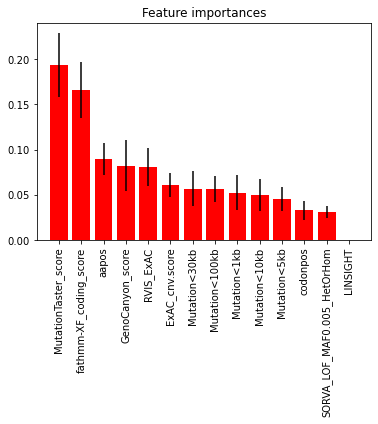

In [3]:
# Try a random forest:

from sklearn.ensemble import RandomForestClassifier
# forest = RandomForestClassifier(random_state=1, class_weight="balanced")
forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
forest.fit(df_train, train_labels)
#ax = plt.gca()
#rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
#svc_disp.plot(ax=ax, alpha=0.8) ## if you want to plot both svm and rf
#plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
feature_labels = list(df_train) # columns names
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(feature_labels[indices[f]])

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), labels=df_train.columns[indices], rotation=90)
plt.xlim([-1, df_train.shape[1]])
plt.show()

In [4]:
print(df_test, y_pred)

                       aapos  codonpos  MutationTaster_score  \
chr pos       ref alt                                          
5   218356    A   C        1         1              1.000000   
    223509    C   T       31         1              1.000000   
    224504    C   T       99         1              1.000000   
    225976    G   A      184         1              1.000000   
    228191    C   T      210         1              1.000000   
...                      ...       ...                   ...   
6   166366861 G   T       36         1              1.000000   
    169751662 A   T        2         2              1.000000   
    169755364 C   A       86         2              0.999858   
    169756386 A   G      122         1              1.000000   
    169769610 T   A      377         2              1.000000   

                       fathmm-XF_coding_score  GenoCanyon_score  LINSIGHT  \
chr pos       ref alt                                                       
5   218356   